In [1]:
#%tensorflow_version 2.x
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
 # raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [2]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model


from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow


%matplotlib inline


## Building a Residual Network




### The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). 

 Here is where you're actually using the power of the Functional API to create a shortcut path: 

In [3]:


def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [4]:


def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding="valid", kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = "same", kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = "valid", kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = "valid", kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training) # Default axis
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

#Building Your First ResNet Model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

    


In [5]:


def ResNet50(input_shape = (64, 64, 3), classes = 5):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE

    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2) 
    X = identity_block(X, 3, [128,128,512])


    ## Stage 4 (≈6 lines)  [256, 256, 1024], "f" is 3 and "s" is 2
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 

    X = BatchNormalization(axis = 3)(X)

    ## Stage 5 (≈3 lines) [512, 512, 2048], "f" is 3 and "s" is 2.
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2) 
    X = identity_block(X, 3, [512, 512, 2048]) 
    X = identity_block(X, 3, [512, 512, 2048])
    #X = Dropout(0.30)(X)
    X = BatchNormalization(axis = 3)(X)
    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = X = AveragePooling2D()(X)

    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [6]:
from tensorflow.keras import backend as K

In [7]:
### Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [8]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

As shown in the Keras Tutorial Notebook, prior to training a model, you need to configure the learning process by compiling the model.

The model is now ready to be trained. The only thing you need now is a dataset!

In [9]:
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, '../input/cassava-leaf-disease-classification/train_images')

train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
image_list = train.image_id

In [10]:
train['label'] = train['label'].astype('str')

In [11]:
train.shape

(21397, 2)

In [12]:
train.head(10)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
5,1000837476.jpg,3
6,1000910826.jpg,2
7,1001320321.jpg,0
8,1001723730.jpg,4
9,1001742395.jpg,3


In [13]:
'''read the disease label into a dataframe'''
data = {"0":"Cassava Bacterial Blight (CBB)",
        "1":"Cassava Brown Streak Disease (CBSD)",
        "2":"Cassava Green Mottle (CGM)",
        "3":"Cassava Mosaic Disease (CMD)",
        "4":"Healthy"}
disease_label = pd.DataFrame(data=data.values(),index=data.keys(),columns=['Disease_Name'])

In [14]:
disease_label

,Disease_Name
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


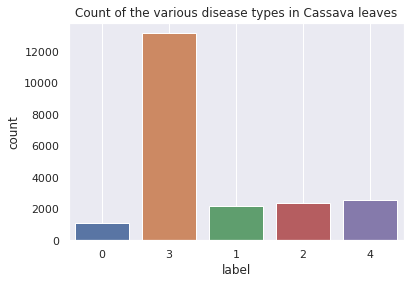

In [15]:
import seaborn as sns
#the count of the various disease types
sns.set_theme(style="darkgrid")
sns.countplot(x='label',data=train)

plt.title('Count of the various disease types in Cassava leaves')
plt.grid()
plt.show()

Text(0.5, 1.0, '151804791.jpg')

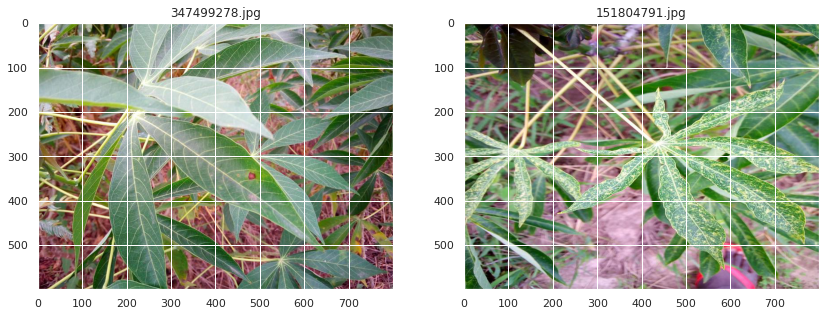

In [16]:
N = np.random.randint(0,high=train.shape[0], size=2, dtype=int)

img = imageio.imread('../input/cassava-leaf-disease-classification/train_images/'+str(image_list[N[0]]))
img2 = imageio.imread('../input/cassava-leaf-disease-classification/train_images/'+str(image_list[N[1]]))
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title(str(image_list[N[0]]))
arr[1].imshow(img2)
arr[1].set_title(str(image_list[N[1]]))
  

  

Run the following cell to train your model on 10 epochs with a batch size of 32. On a GPU, it should take less than 2 minutes. 

Let's see how this model (trained on only two epochs) performs on the test set.

In [17]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,rescale=1./255)

train_generator = train_data_generator.flow_from_dataframe(
    train,
    directory = '../input/cassava-leaf-disease-classification/train_images',
    x_col='image_id',
    y_col="label",
    subset='training',
    color_mode='rgb',
    batch_size=40,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64)
)


Found 17118 validated image filenames belonging to 5 classes.


In [18]:
validation_generator = train_data_generator.flow_from_dataframe(
    train,
    directory = '../input/cassava-leaf-disease-classification/train_images',
    x_col='image_id',
    y_col='label',
    subset='validation',
    color_mode='rgb',
    batch_size=40,
    shuffle=True,
    class_model='categorical',
    target_size=(64,64)
)

Found 4279 validated image filenames belonging to 5 classes.


In [19]:
model = ResNet50(input_shape = (64, 64, 3), classes = 5)

2021-12-21 22:35:20.245805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 22:35:20.332238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 22:35:20.333012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 22:35:20.334405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.load_weights("../input/myres3/best_model_weights.h5")
model.evaluate(validation_generator)

2021-12-21 22:35:26.738739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 22:35:29.044799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


107/107 [==============================] - 53s 433ms/step - loss: 0.1878 - accuracy: 0.9334


[0.18782520294189453, 0.9333956241607666]

In [22]:
from PIL import Image

In [23]:
sub = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
sub['label']=sub['label'].astype('str')

preds = []
# preds_no_argmax = []


test_images = os.listdir('../input/cassava-leaf-disease-classification/test_images/')
preds = []

for i in test_images:
    image = Image.open(f'../input/cassava-leaf-disease-classification/test_images/{i}')
    image = image.resize((64,64))
    image = np.expand_dims(image, axis=0)
    preds.append(np.argmax(model.predict(image)))




In [24]:

submissions=pd.DataFrame({'image_id':test_images,'label':preds})

file_name='submission.csv'

submissions.to_csv(file_name,index=None)

In [25]:
pd.read_csv('submission.csv')

,image_id,label
0,2216849948.jpg,3
